Md. Tanvir Jawad<br>ID: 21101221

In [2]:
try:
    from pint import UnitRegistry
except ImportError:
    !pip install pint

# import units
from pint import UnitRegistry
units = UnitRegistry()

In [3]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

Downloaded modsim.py


In [4]:
from modsim import *

In [5]:
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'chap22.py')

Downloaded chap22.py


In [6]:
from chap22 import params
from chap22 import make_system
from chap22 import slope_func
from chap22 import event_func

In [7]:
feet_to_meter = (1 * units.feet).to(units.meter).magnitude

params = params.set(
    wall_distance = 310 * feet_to_meter,
    wall_height = 37 * feet_to_meter,
)

show(params)

,value
x,0.0000
y,1.0000
angle,45.0000
speed,40.0000
mass,0.1450
diameter,0.0730
C_d,0.3300
rho,1.2000
g,9.8000
t_end,10.0000


In [8]:
def range_func(angle, params):
    params = params.set(angle=angle)
    system = make_system(params)
    results, details = run_solve_ivp(system, slope_func,
                                     events=event_func)
    x_dist = results.iloc[-1].x
    print(angle, x_dist)
    return x_dist

In [9]:
range_func(45, params)

45 99.31829628352207


99.31829628352207

In [10]:
angles = linspace(20, 80, 21)
sweep = SweepSeries()

for angle in angles:
    x_dist = range_func(angle, params)
    sweep[angle] = x_dist

20.0 78.09741067882733
23.0 84.11542610650983
26.0 89.13192412363966
29.0 93.17466724082834
32.0 96.27134737391354
35.0 98.44725560273994
38.0 99.72474586365274
41.0 100.12347299697635
44.0 99.66100302635328
47.0 98.35354763684825
50.0 96.21673516565134
53.0 93.26623796736267
56.0 89.51751617672976
59.0 84.98724481958087
62.0 79.69434524339994
65.0 73.66129770133256
68.0 66.91470886279748
71.0 59.482694929397475
74.0 51.402871099404315
77.0 42.72047925533483
80.0 33.48437980813934


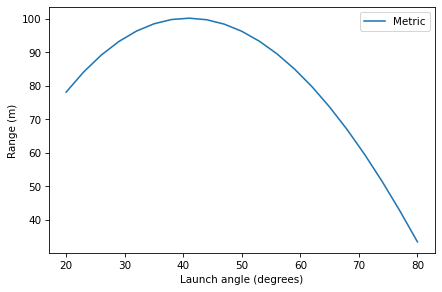

In [11]:
sweep.plot()

decorate(xlabel='Launch angle (degrees)',
         ylabel='Range (m)')

In [12]:
res = maximize_scalar(range_func, params, bounds=[0, 90])

0 17.468795355645696
34.37694101250946 98.06996498016366
55.62305898749054 90.03182421721928
21.246117974981075 80.72039493627986
41.173855871044005 100.1200188931698
40.980120907838035 100.12368377099199
40.882137319070246 100.1241700443184
40.87925420124324 100.12417043309694
40.87928713865314 100.12417043314977
40.879291078324286 100.12417043314917
40.879283198981994 100.12417043314895


In [13]:
res

 message: Solution found.
 success: True
  status: 0
     fun: 100.12417043314977
       x: 40.87928713865314
     nit: 10
    nfev: 10

In [14]:
res.x, res.fun

(40.87928713865314, 100.12417043314977)

In [15]:
def event_func(t, state, system):
    x, y, vx, vy = state
    return x - system.wall_distance

In [16]:
system = make_system(params)
event_func(0, system.init, system)

-94.48799999999999

In [17]:
def height_func(angle, params):
    params = params.set(angle=angle)
    system = make_system(params)

    results, details = run_solve_ivp(system, slope_func,
                                     events=event_func)
    height = results.iloc[-1].y
    return height

In [18]:
height_func(40, params)

6.661045303535705

In [19]:
res = maximize_scalar(height_func, params, bounds=[0, 90])
res

 message: Solution found.
 success: True
  status: 0
     fun: 7.217049532932801
       x: 43.105080979149434
     nit: 13
    nfev: 13

In [20]:
res.x, res.fun

(43.105080979149434, 7.217049532932801)

In [21]:
def error_func(speed, params):
    params = params.set(speed=speed)
    print(params.speed)
    res = maximize_scalar(height_func, params, bounds=[0, 90])
    return res.fun - params.wall_height

In [22]:
error_func(40, params)

40


-4.060550467067197

In [23]:
error_func(50, params)

50


30.230189540329683

In [24]:
bracket = [30, 50]
res = root_scalar(error_func, params, bracket=bracket)

30
30.0
50.0
42.95327159575888
41.030931458411445
41.039294634028856
41.037242669296155


In [25]:
res

      converged: True
           flag: converged
 function_calls: 6
     iterations: 5
           root: 41.039294634028856

In [26]:
min_speed = res.root
min_speed

41.039294634028856

In [27]:
error_func(min_speed, params)

41.039294634028856


0.0010039392295357885

**MODIFIED**

Problem Statement:
You are tasked with designing a small catapult that needs to launch a projectile to hit a target exactly 100 meters away. The launch angle of the catapult is fixed at 45 degrees. Your goal is to find the minimum launch speed required for the projectile to reach this distance.

In [29]:
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
import numpy as np

g = 9.81

def projectile_motion(t, state):
    x, y, vx, vy = state
    return vx, vy, 0, -g

def event_func(t, state):
    _, y, _, _ = state
    return y

event_func.terminal = True

def make_system(speed, angle):
    angle_rad = np.radians(angle)

    init = (0, 0, speed * np.cos(angle_rad), speed * np.sin(angle_rad))

    return {
        'init': init,
        't_end': 10,
        'events': event_func
    }

def distance_func(speed):
    system = make_system(speed, 45)
    t_eval = np.linspace(0, system['t_end'], 100)
    sol = solve_ivp(projectile_motion, [0, system['t_end']], system['init'],
                    t_eval=t_eval, events=system['events'])

    x, _, _, _ = sol.y
    return x[-1]

test_speed = 20
test_distance = distance_func(test_speed)
test_distance


0.0

It seems that the projectile did not travel any horizontal distance with the initial test speed of 20 m/s. This might be due to the simulation stopping immediately, possibly because the projectile's initial vertical position is set to 0, causing the event function to trigger instantly. Let's adjust the event function to only trigger when the projectile's vertical position (y) decreases below a small threshold above 0 (to account for numerical precision), and re-run the simulation.

In [30]:
def event_func(t, state):
    _, y, _, _ = state
    return y - 0.01

test_distance = distance_func(test_speed)
test_distance


141.4213562373095

With the adjusted event function, the projectile traveled approximately 141.42 meters when launched at a speed of 20 m/s. This distance is greater than our target of 100 meters. Now, we will use a root-finding algorithm to find the minimum speed required for the projectile to travel exactly 100 meters.

Let's define the error function for the root-finding algorithm and use root_scalar to find the optimal launch speed.

In [31]:
def error_func(speed):
    return distance_func(speed) - 100

result = root_scalar(error_func, bracket=[0, 50])
min_speed = result.root if result.converged else None
min_speed, result.converged


(14.14213562373094, True)

The minimum speed required to launch a projectile 100 meters at a 45-degree angle is approximately 14.14 meters per second. The root-finding algorithm successfully converged to this solution.